<a href="https://colab.research.google.com/github/EstaVS/AI_eye_model/blob/main/eye_images_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
# Define the path for eye images data
path = '/content/drive/My Drive/Colab_Notebooks/AI_eye_image_project/eye_images_data'

In [ ]:
if os.path.exists(path):
    print("Path exists!")
    print(os.listdir(path))
else:
    print("Path does not exist. Check Google Drive mount and folder structure.")

Path exists!
['1_normal', '2_cataract', '2_glaucoma']


In [ ]:
normal = os.path.join(path,'1_normal')
cataract = os.path.join(path,'2_cataract')
glaucoma = os.path.join(path, '2_glaucoma')

print("Number of normal eye images:", len(os.listdir(normal)))
print("Number of cataract eye images:", len(os.listdir(cataract)))
print("Number of glaucoma eye images:", len(os.listdir(glaucoma)))

Number of normal eye images: 302
Number of cataract eye images: 300
Number of glaucoma eye images: 302


In [ ]:
import numpy as np
import cv2  # used to read images

def load_images(directories, n_images=900000):
    """
    Reads in images and assigns class labels
    Parameters:
        directories: A list of the sub-directories
        n_images:    The maximum number of images to load from each directory
    Returns:
        images (numpy.ndarray) : Image data
        label (numpy.ndarray      : Labels of each image
    """
    images = []
    labels = []
    for label, sub_dir in enumerate(directories):
        num=1
        for file_name in os.listdir(sub_dir):
            if num > n_images:
                break
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (300, 300))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                num+=1
    return np.array(images), np.array(labels)

Here, I wrote a function to augment the Cataract & Glaucoma images - this is both to fix the overfitting and introduce more variation for training the model in diagnosing Cataract & Glaucoma.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Function to apply augmentation and save images
def augment_images(image_dir, save_dir, num_augmented=2):
    for img_name in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, img_name))  # Load image
        img_array = img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Reshape for ImageDataGenerator

        # Generate and save augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=5, save_to_dir=save_dir,
                                  save_prefix="aug", save_format="png"):
            i += 1
            if i >= num_augmented:  # Number of new images per original image
                break

# Apply augmentation to cataract and glaucoma images
# augment_images(cataract, cataract)
# augment_images(glaucoma, glaucoma)

In [ ]:
print("Number of normal eye images:", len(os.listdir(normal)))
print("Number of cataract eye images:", len(os.listdir(cataract)))
print("Number of glaucoma eye images:", len(os.listdir(glaucoma)))

Number of normal eye images: 302
Number of cataract eye images: 300
Number of glaucoma eye images: 302


In [ ]:
images, labels = load_images([normal, cataract, glaucoma ], 900)

In [ ]:
images.shape

(902, 300, 300, 3)

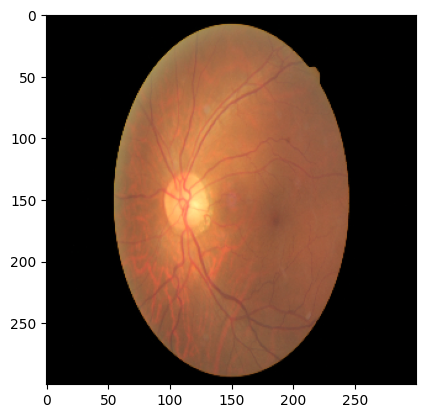

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[200],cmap="gray")

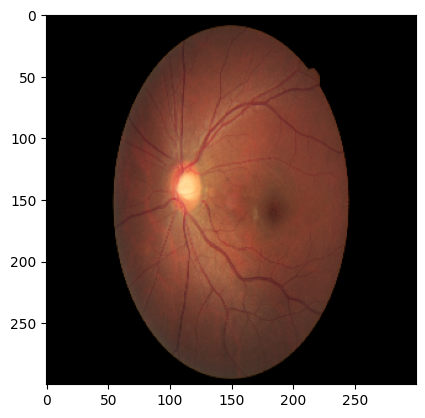

In [ ]:
plt.imshow(images[600],cmap="gray")

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=487)

In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = 3  # Match the number of classes in the dataset
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Initially, I'm going to test this with a manually built model that needs training. I will switch to ResNet later on.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Apply L2 Regularization to Dense and Conv2D layers
model = Sequential([

        Conv2D(64, (3, 3), activation='relu', input_shape=(300,300,3), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flatten and fully connect layers
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(3, activation='softmax')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow.keras.backend as K

# Causes errors so has been removed from model.compile for now

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0) errors
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)

        # Compute categorical cross-entropy
        cross_entropy = K.categorical_crossentropy(y_true, y_pred)

        # Compute probability of the correct class
        pt = K.sum(y_true * y_pred, axis=-1)

        # Compute focal loss weights correctly
        weights = alpha * K.pow(1 - pt, gamma)

        # Compute final focal loss
        focal_loss = weights * cross_entropy  # Element-wise multiplication

        return K.mean(focal_loss)  # Average over batch

    return loss

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 298, 298, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 298, 298, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 149, 149, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 147, 147, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 147, 147, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 71, 71, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 71, 71, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 35, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 33, 33, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 33, 33, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,332,547 (69.93 MB)

 Trainable params: 18,330,627 (69.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Ensure all labels are included
unique_classes = np.unique(y_train) # Extract unique class labels

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

# Convert to dictionary
class_weights_dict = {i: class_weights[i] for i in range(len(unique_classes))}
print("Computed Class Weights:", class_weights_dict)

Computed Class Weights: {0: 1.0140646976090013, 1: 0.9931129476584022, 2: 0.9931129476584022}


In [ ]:
history = model.fit(x=X_train, y=y_train_cat, batch_size=32,
                      epochs=50, shuffle=True,
                      validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 356ms/step - accuracy: 0.3981 - loss: 16.3631 - val_accuracy: 0.3793 - val_loss: 9.9077
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 266ms/step - accuracy: 0.5463 - loss: 9.7558 - val_accuracy: 0.5586 - val_loss: 9.5527
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.7165 - loss: 9.2340 - val_accuracy: 0.5793 - val_loss: 9.7115
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.7320 - loss: 9.1024 - val_accuracy: 0.6207 - val_loss: 9.3912
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.7613 - loss: 9.0363 - val_accuracy: 0.6207 - val_loss: 9.3004
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.7900 - loss: 8.8879 - val_accuracy: 0.6414 - val_loss: 9.0949
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 254ms/step - accuracy: 0.7785 - loss: 8.7396 - val_accuracy: 0.6621 - val_loss: 8.9242
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.8260 - loss: 8.5881 - val_accuracy:

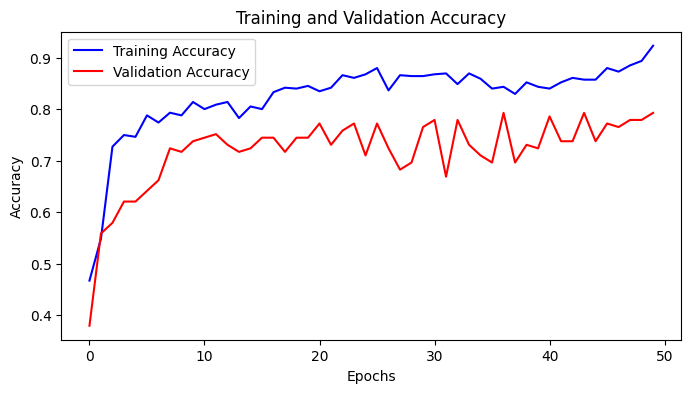

In [ ]:
epochs = history.epoch
accuracy_values = history.history['accuracy']
val_accuracy_values = history.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(epochs, accuracy_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

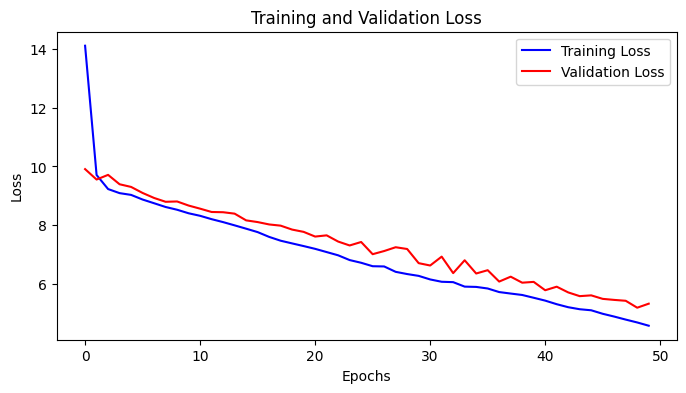

In [ ]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Use the model to make predictions on the testset
y_pred_prob = model.predict(X_test)
# Convert predictions to class labels
y_pred = y_pred_prob.argmax(axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


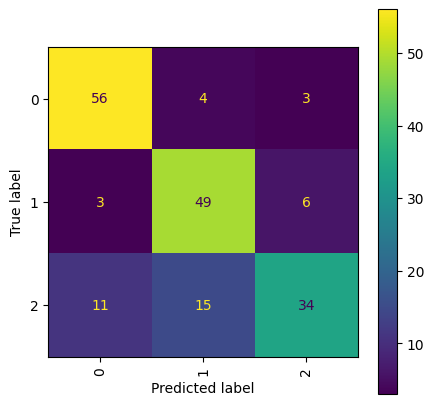

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm  = confusion_matrix(y_test, y_pred)
cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

In [ ]:
from sklearn.metrics  import classification_report

print('Classification Report:')
print(classification_report(y_test,y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        63
           1       0.72      0.84      0.78        58
           2       0.79      0.57      0.66        60

    accuracy                           0.77       181
   macro avg       0.77      0.77      0.76       181
weighted avg       0.77      0.77      0.76       181



ResNet50 is a pre-trained CNN model optimised for images - This model shows significant improvements. Notably, the differences between the Accuracy Validation Accuracy & Loss vs Validation Loss.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Trying ResNet instead of a manually built model

# Load pre-trained ResNet50 (without top layers)
ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze convolutional layers to retain learned features - Inherent to pre-trained ResNet model
ResNet_model.trainable = False

# Create a new model
ResNet = Sequential([
    ResNet_model,
    GlobalAveragePooling2D(),  # Better than Flatten for feature extraction
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

In [ ]:
ResNet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ResNet.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 10, 10, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history_res = ResNet.fit(x=X_train, y=y_train_cat, batch_size=32,
                      epochs=50, shuffle=True,
                      validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - accuracy: 0.8900 - loss: 0.5900 - val_accuracy: 0.8966 - val_loss: 0.6145
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9057 - loss: 0.5703 - val_accuracy: 0.8966 - val_loss: 0.6223
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.9085 - loss: 0.5650 - val_accuracy: 0.8897 - val_loss: 0.6244
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9131 - loss: 0.5585 - val_accuracy: 0.8897 - val_loss: 0.6051
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.9127 - loss: 0.5658 - val_accuracy: 0.8966 - val_loss: 0.6132
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9228 - loss: 0.5537 - val_accuracy: 0.8966 - val_loss: 0.6068
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9244 - loss: 0.5426 - val_accuracy: 0.8966 - val_loss: 0.5960
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.9288 - loss: 0.5327 - val_accuracy: 0.

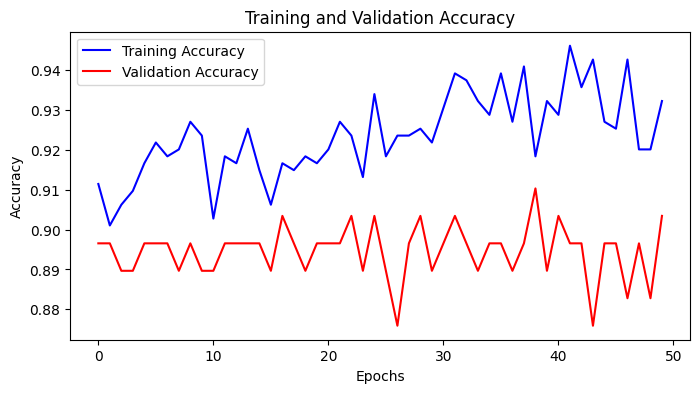

In [ ]:
epochs_res = history_res.epoch
accuracy_values_res = history_res.history['accuracy']
val_accuracy_values_res = history_res.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(epochs_res, accuracy_values_res, 'b', label='Training Accuracy')
plt.plot(epochs_res, val_accuracy_values_res, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

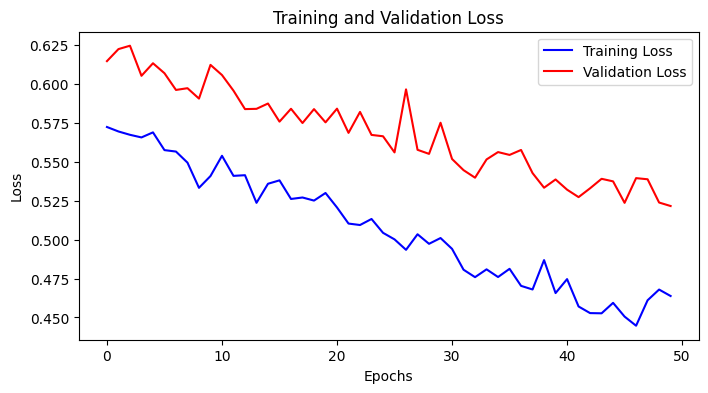

In [ ]:
loss_values_res = history_res.history['loss']
val_loss_values_res = history_res.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(epochs_res, loss_values_res, 'b', label='Training Loss')
plt.plot(epochs_res, val_loss_values_res, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_prob_res = ResNet.predict(X_test)
y_pred_res = y_pred_prob_res.argmax(axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


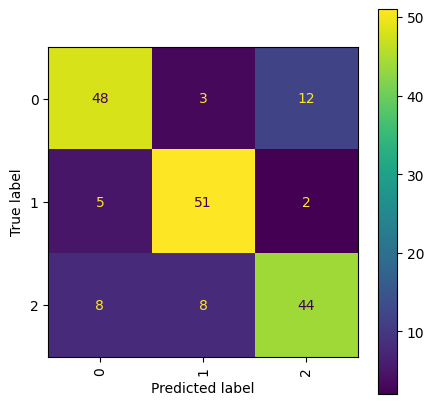

In [ ]:
cm_res  = confusion_matrix(y_test, y_pred_res)
cmdisp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp_res.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

In [ ]:
print('ResNet Classification Report:')
print(classification_report(y_test,y_pred_res))

ResNet Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        63
           1       0.82      0.88      0.85        58
           2       0.76      0.73      0.75        60

    accuracy                           0.79       181
   macro avg       0.79      0.79      0.79       181
weighted avg       0.79      0.79      0.79       181

